In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121, densenet201
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

2024-04-26 18:23:38.675651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 18:23:38.884497: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 18:23:39.584188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib:/opt/Qt/6.3.1/gcc_6/lib
2024-04-26 18:23:39.584352: W tensorflow/stream_executor/platform/default/dso_loader.cc:

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
df = pd.read_csv("/home/12559743/DAVI/IC/Codes/data_aug.csv")
print(len(df))

1455


In [4]:
print(df.iloc[1430]['Patient'], df.iloc[1430]['PAN Date'], df.iloc[1430]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


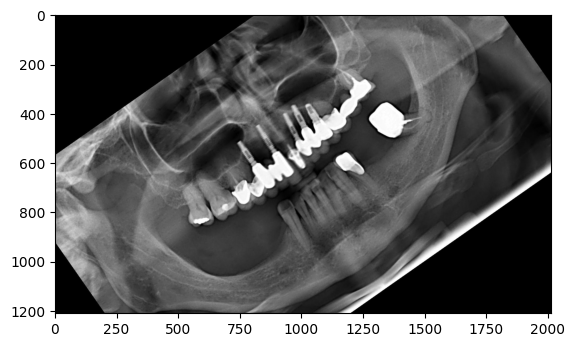

In [5]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

In [6]:
from sklearn.model_selection import train_test_split as splitter
import random

def data_separator(data, train_rate=0.70, val_rate=0.50, SEED=42):
    
    '''
        Applies train, val, test split.
    '''
    
    # Separando train, val and test IMAGE path list
    
    if not val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        return train, test
        
    elif val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        val, test = splitter(test, test_size= 1-val_rate, shuffle=True, random_state=SEED)

        return train, val, test 



In [7]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

1164 145 146


In [8]:
train_list = (list(train['PAN Path']), list(train['Sex']))
val_list = (list(val['PAN Path']), list(val['Sex']))
test_list = (list(test['PAN Path']), list(test['Sex']))

print(len(train), len(val), len(test))

1164 145 146


In [9]:
image_list_train =[]
image_list_train_y = []

for i in range(len(train)):
    #print(i)
    x = cv2.imread(train_list[0][i])
    x = cv2.resize(x, (256, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_train.append(x)
    image_list_train_y.append(train_list[1][i])
    
image_list_val = []
image_list_val_y = []

for i in range(len(val)):
    #print(i)
    x = cv2.imread(val_list[0][i])
    x = cv2.resize(x, (256, 256))
    X = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)
    image_list_val.append(x)
    image_list_val_y.append(val_list[1][i])
    
    
    
image_list_test = []
image_list_test_y = []

for i in range(len(test)):
    #print(i)
    x = cv2.imread(test_list[0][i])
    x = cv2.resize(x, (256, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_test.append(x)
    image_list_test_y.append(test_list[1][i])

In [10]:
image_list_train_y = np.array(image_list_train_y)
image_list_val_y = np.array(image_list_val_y)
image_list_test_y = np.array(image_list_test_y)

In [11]:
image_list_test_y[7]

0

In [12]:
w, h , c= image_list_train[0].shape

In [13]:
image_list_train = np.array(image_list_train)
image_list_val = np.array(image_list_val)
image_list_test = np.array(image_list_test)

In [14]:
image_list_train = image_list_train.reshape((-1, w,h,3))
image_list_val = image_list_val.reshape((-1, w,h,3))
image_list_test = image_list_test.reshape((-1, w,h,3))

In [15]:
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224,0.225 ])
transform = transforms.Compose([
    transforms.ToTensor()
])

image_list_train_tensor = torch.stack([transform(image) for image in image_list_train])
image_list_val_tensor = torch.stack([transform(image) for image in image_list_val])
image_list_test_tensor = torch.stack([transform(image) for image in image_list_test])

In [16]:
image_list_train_tensor.shape

torch.Size([1164, 3, 256, 256])

In [17]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
def transform_image(image):
    image = torch.tensor(image, dtype=torch.float32)
    
    image = image / 255.0
    return image

dataset = CustomDataset(image_list_train, image_list_train_y, transform = transform_image)

In [18]:
batch_size = 16

train_ds = CustomDataset(image_list_train_tensor, image_list_train_y, transform_image)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = CustomDataset(image_list_val_tensor, image_list_val_y, transform_image)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)

test_ds = CustomDataset(image_list_test_tensor, image_list_test_y, transform_image)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Resto do seu código aqui


In [77]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s
import timm

'''
Construir primeira camada de rede neural com pesos iguais
'''
class MyModel(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super(MyModel, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 2, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
        )

        self.linear_relu = nn.Sequential(
            nn.Linear(24200,124),
            nn.Dropout(drop_prob),
            nn.ReLU(),
            nn.Linear(124, 32),
            nn.Dropout(drop_prob),
            nn.ReLU(),
            nn.Linear(32,1)
        )

        

        
    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1)
        logists = self.linear_relu(x)
        return logists
    
    
    
drop_prob = 0.2
model = MyModel(drop_prob).to(device)

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s
import timm

'''
Construir primeira camada de rede neural com pesos iguais
'''
class MyModel(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super(MyModel, self).__init__()
        self.linear_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(196608, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        

        
    def forward(self, x):
        model = self.linear_net(x)
        return model
    
    
drop_prob = 0.2
model = MyModel(drop_prob).to(device)

In [23]:
print(model)

MyModel(
  (linear_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [69]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
from monai.networks.nets import DenseNet121

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1).to(device)

In [21]:
print(model)

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [22]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [23]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), 1e-4)


In [24]:
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp31q__9g2


In [25]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

max_epochs = 50
val_interval = 1




model_data = None
single_complexity = list()
single_entropy = list()
single_disequilibrium = list()
single_loss = list()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        # EXTRACT MODEL DATA
        model_data = extract_model_data(model, model_data)
        myp = torch.nn.utils.parameters_to_vector(model.parameters())
        single_complexity.append(Complexity().complexity(myp))
        single_loss.append(loss.item())
        single_disequilibrium.append(Complexity().desiquilibrium(myp))
        single_entropy.append(Complexity().entropy(myp))

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(
                y_pred, y)
            metric_values.append(auc_metric)
            '''
            y_one_hot = label_binarize(y.cpu().numpy(), classes=np.arange(num_classes))
            fpr, tpr, _ = roc_curve(y_one_hot.ravel(), y_pred.cpu().numpy().ravel())
            auc_value = auc(fpr, tpr)
            '''
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.7642
2/72, train_loss: 0.6358
3/72, train_loss: 0.5299
4/72, train_loss: 0.5394
5/72, train_loss: 0.3951
6/72, train_loss: 0.3989
7/72, train_loss: 0.5671
8/72, train_loss: 0.5490
9/72, train_loss: 0.5258
10/72, train_loss: 0.5998
11/72, train_loss: 0.6950
12/72, train_loss: 0.4846
13/72, train_loss: 0.5016
14/72, train_loss: 0.3895
15/72, train_loss: 0.7326
16/72, train_loss: 0.4349
17/72, train_loss: 0.6274
18/72, train_loss: 0.5014
19/72, train_loss: 0.5018
20/72, train_loss: 0.4400
21/72, train_loss: 0.3415
22/72, train_loss: 0.4900
23/72, train_loss: 0.4063
24/72, train_loss: 0.4188
25/72, train_loss: 0.2794
26/72, train_loss: 0.2959
27/72, train_loss: 0.4179
28/72, train_loss: 0.4855
29/72, train_loss: 0.2880
30/72, train_loss: 0.4083
31/72, train_loss: 0.3849
32/72, train_loss: 0.3898
33/72, train_loss: 0.6729
34/72, train_loss: 0.4005
35/72, train_loss: 0.3936
36/72, train_loss: 0.4644
37/72, train_loss: 0.5085
38/72, train_loss: 0.4060
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 1 current AUC: 0.8755 current accuracy: 0.6000 best AUC: 0.8755 at epoch: 1
----------
epoch 2/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.4422
2/72, train_loss: 0.4161
3/72, train_loss: 0.3445
4/72, train_loss: 0.4578
5/72, train_loss: 0.2186
6/72, train_loss: 0.3880
7/72, train_loss: 0.5100
8/72, train_loss: 0.3272
9/72, train_loss: 0.5087
10/72, train_loss: 0.4221
11/72, train_loss: 0.4756
12/72, train_loss: 0.3016
13/72, train_loss: 0.3366
14/72, train_loss: 0.4667
15/72, train_loss: 0.3391
16/72, train_loss: 0.3615
17/72, train_loss: 0.3789
18/72, train_loss: 0.2532
19/72, train_loss: 0.6391
20/72, train_loss: 0.3114
21/72, train_loss: 0.1677
22/72, train_loss: 0.2739
23/72, train_loss: 0.3564
24/72, train_loss: 0.2861
25/72, train_loss: 0.2753
26/72, train_loss: 0.3451
27/72, train_loss: 0.2409
28/72, train_loss: 0.1867
29/72, train_loss: 0.5243
30/72, train_loss: 0.2349
31/72, train_loss: 0.2240
32/72, train_loss: 0.3048
33/72, train_loss: 0.3144
34/72, train_loss: 0.4836
35/72, train_loss: 0.2158
36/72, train_loss: 0.5472
37/72, train_loss: 0.2148
38/72, train_loss: 0.2669
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 2 current AUC: 0.9461 current accuracy: 0.6000 best AUC: 0.9461 at epoch: 2
----------
epoch 3/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0896
2/72, train_loss: 0.2662
3/72, train_loss: 0.2791
4/72, train_loss: 0.2634
5/72, train_loss: 0.5399
6/72, train_loss: 0.4297
7/72, train_loss: 0.6031
8/72, train_loss: 0.1652
9/72, train_loss: 0.4065
10/72, train_loss: 0.2182
11/72, train_loss: 0.2816
12/72, train_loss: 0.2430
13/72, train_loss: 0.1872
14/72, train_loss: 0.5482
15/72, train_loss: 0.1488
16/72, train_loss: 0.1844
17/72, train_loss: 0.3641
18/72, train_loss: 0.1943
19/72, train_loss: 0.1558
20/72, train_loss: 0.1679
21/72, train_loss: 0.3121
22/72, train_loss: 0.2450
23/72, train_loss: 0.3064
24/72, train_loss: 0.2797
25/72, train_loss: 0.2790
26/72, train_loss: 0.0981
27/72, train_loss: 0.2884
28/72, train_loss: 0.3639
29/72, train_loss: 0.4364
30/72, train_loss: 0.2507
31/72, train_loss: 0.3800
32/72, train_loss: 0.1724
33/72, train_loss: 0.3524
34/72, train_loss: 0.3665
35/72, train_loss: 0.2957
36/72, train_loss: 0.2666
37/72, train_loss: 0.4994
38/72, train_loss: 0.3776
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 3 current AUC: 0.9509 current accuracy: 0.6000 best AUC: 0.9509 at epoch: 3
----------
epoch 4/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.2265
2/72, train_loss: 0.2514
3/72, train_loss: 0.6398
4/72, train_loss: 0.2277
5/72, train_loss: 0.2842
6/72, train_loss: 0.2781
7/72, train_loss: 0.2491
8/72, train_loss: 0.3250
9/72, train_loss: 0.4574
10/72, train_loss: 0.3523
11/72, train_loss: 0.3589
12/72, train_loss: 0.2476
13/72, train_loss: 0.4032
14/72, train_loss: 0.3206
15/72, train_loss: 0.3541
16/72, train_loss: 0.1305
17/72, train_loss: 0.2295
18/72, train_loss: 0.2183
19/72, train_loss: 0.2030
20/72, train_loss: 0.2117
21/72, train_loss: 0.3675
22/72, train_loss: 0.1416
23/72, train_loss: 0.2360
24/72, train_loss: 0.2827
25/72, train_loss: 0.3239
26/72, train_loss: 0.2457
27/72, train_loss: 0.1927
28/72, train_loss: 0.6942
29/72, train_loss: 0.1926
30/72, train_loss: 0.3125
31/72, train_loss: 0.2920
32/72, train_loss: 0.3395
33/72, train_loss: 0.1417
34/72, train_loss: 0.3546
35/72, train_loss: 0.4177
36/72, train_loss: 0.5476
37/72, train_loss: 0.1262
38/72, train_loss: 0.2538
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 4 current AUC: 0.9465 current accuracy: 0.6000 best AUC: 0.9509 at epoch: 3
----------
epoch 5/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0808
2/72, train_loss: 0.2435
3/72, train_loss: 0.1426
4/72, train_loss: 0.2069
5/72, train_loss: 0.3336
6/72, train_loss: 0.2427
7/72, train_loss: 0.1518
8/72, train_loss: 0.2690
9/72, train_loss: 0.0511
10/72, train_loss: 0.1568
11/72, train_loss: 0.3393
12/72, train_loss: 0.0668
13/72, train_loss: 0.2410
14/72, train_loss: 0.1960
15/72, train_loss: 0.1770
16/72, train_loss: 0.1055
17/72, train_loss: 0.1133
18/72, train_loss: 0.2930
19/72, train_loss: 0.1000
20/72, train_loss: 0.1009
21/72, train_loss: 0.4737
22/72, train_loss: 0.4559
23/72, train_loss: 0.2402
24/72, train_loss: 0.2394
25/72, train_loss: 0.1270
26/72, train_loss: 0.1138
27/72, train_loss: 0.2466
28/72, train_loss: 0.1094
29/72, train_loss: 0.1452
30/72, train_loss: 0.1555
31/72, train_loss: 0.0872
32/72, train_loss: 0.0999
33/72, train_loss: 0.1027
34/72, train_loss: 0.2304
35/72, train_loss: 0.0806
36/72, train_loss: 0.0794
37/72, train_loss: 0.0326
38/72, train_loss: 0.1384
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 5 current AUC: 0.9643 current accuracy: 0.6000 best AUC: 0.9643 at epoch: 5
----------
epoch 6/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0740
2/72, train_loss: 0.0933
3/72, train_loss: 0.1432
4/72, train_loss: 0.1128
5/72, train_loss: 0.1306
6/72, train_loss: 0.1903
7/72, train_loss: 0.1124
8/72, train_loss: 0.2509
9/72, train_loss: 0.1207
10/72, train_loss: 0.2928
11/72, train_loss: 0.0305
12/72, train_loss: 0.2618
13/72, train_loss: 0.0494
14/72, train_loss: 0.1236
15/72, train_loss: 0.1124
16/72, train_loss: 0.3308
17/72, train_loss: 0.1117
18/72, train_loss: 0.2562
19/72, train_loss: 0.2313
20/72, train_loss: 0.0686
21/72, train_loss: 0.2302
22/72, train_loss: 0.3047
23/72, train_loss: 0.0327
24/72, train_loss: 0.0761
25/72, train_loss: 0.2254
26/72, train_loss: 0.1206
27/72, train_loss: 0.2012
28/72, train_loss: 0.1319
29/72, train_loss: 0.0893
30/72, train_loss: 0.0792
31/72, train_loss: 0.0644
32/72, train_loss: 0.0897
33/72, train_loss: 0.1417
34/72, train_loss: 0.0461
35/72, train_loss: 0.0770
36/72, train_loss: 0.2462
37/72, train_loss: 0.1238
38/72, train_loss: 0.0622
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 6 current AUC: 0.9546 current accuracy: 0.6000 best AUC: 0.9643 at epoch: 5
----------
epoch 7/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.3441
2/72, train_loss: 0.0767
3/72, train_loss: 0.1881
4/72, train_loss: 0.2389
5/72, train_loss: 0.0348
6/72, train_loss: 0.1497
7/72, train_loss: 0.0494
8/72, train_loss: 0.0718
9/72, train_loss: 0.0857
10/72, train_loss: 0.0475
11/72, train_loss: 0.0412
12/72, train_loss: 0.1116
13/72, train_loss: 0.1319
14/72, train_loss: 0.0197
15/72, train_loss: 0.0873
16/72, train_loss: 0.0388
17/72, train_loss: 0.0363
18/72, train_loss: 0.1700
19/72, train_loss: 0.1512
20/72, train_loss: 0.0216
21/72, train_loss: 0.0535
22/72, train_loss: 0.3878
23/72, train_loss: 0.3544
24/72, train_loss: 0.0288
25/72, train_loss: 0.0627
26/72, train_loss: 0.1473
27/72, train_loss: 0.4176
28/72, train_loss: 0.1237
29/72, train_loss: 0.2710
30/72, train_loss: 0.3896
31/72, train_loss: 0.0706
32/72, train_loss: 0.2234
33/72, train_loss: 0.0935
34/72, train_loss: 0.2993
35/72, train_loss: 0.0676
36/72, train_loss: 0.0521
37/72, train_loss: 0.2904
38/72, train_loss: 0.1310
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 7 current AUC: 0.9463 current accuracy: 0.6000 best AUC: 0.9643 at epoch: 5
----------
epoch 8/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0564
2/72, train_loss: 0.1245
3/72, train_loss: 0.1125
4/72, train_loss: 0.2251
5/72, train_loss: 0.0807
6/72, train_loss: 0.0580
7/72, train_loss: 0.0372
8/72, train_loss: 0.1117
9/72, train_loss: 0.0156
10/72, train_loss: 0.0542
11/72, train_loss: 0.0376
12/72, train_loss: 0.0349
13/72, train_loss: 0.0804
14/72, train_loss: 0.0361
15/72, train_loss: 0.0706
16/72, train_loss: 0.1507
17/72, train_loss: 0.0248
18/72, train_loss: 0.0776
19/72, train_loss: 0.0394
20/72, train_loss: 0.1142
21/72, train_loss: 0.0118
22/72, train_loss: 0.0640
23/72, train_loss: 0.0251
24/72, train_loss: 0.2712
25/72, train_loss: 0.0750
26/72, train_loss: 0.0554
27/72, train_loss: 0.4092
28/72, train_loss: 0.2223
29/72, train_loss: 0.0241
30/72, train_loss: 0.1144
31/72, train_loss: 0.1368
32/72, train_loss: 0.3808
33/72, train_loss: 0.0816
34/72, train_loss: 0.0104
35/72, train_loss: 0.1124
36/72, train_loss: 0.0472
37/72, train_loss: 0.2502
38/72, train_loss: 0.0659
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 8 current AUC: 0.9627 current accuracy: 0.6000 best AUC: 0.9643 at epoch: 5
----------
epoch 9/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0187
2/72, train_loss: 0.0150
3/72, train_loss: 0.2288
4/72, train_loss: 0.0673
5/72, train_loss: 0.3724
6/72, train_loss: 0.1174
7/72, train_loss: 0.2293
8/72, train_loss: 0.3035
9/72, train_loss: 0.0551
10/72, train_loss: 0.1483
11/72, train_loss: 0.0635
12/72, train_loss: 0.0217
13/72, train_loss: 0.1060
14/72, train_loss: 0.0688
15/72, train_loss: 0.0978
16/72, train_loss: 0.0456
17/72, train_loss: 0.0564
18/72, train_loss: 0.0366
19/72, train_loss: 0.0651
20/72, train_loss: 0.1523
21/72, train_loss: 0.0782
22/72, train_loss: 0.1709
23/72, train_loss: 0.0627
24/72, train_loss: 0.0224
25/72, train_loss: 0.0455
26/72, train_loss: 0.2251
27/72, train_loss: 0.0248
28/72, train_loss: 0.0230
29/72, train_loss: 0.0737
30/72, train_loss: 0.1465
31/72, train_loss: 0.1312
32/72, train_loss: 0.0630
33/72, train_loss: 0.0113
34/72, train_loss: 0.0453
35/72, train_loss: 0.2077
36/72, train_loss: 0.0303
37/72, train_loss: 0.0893
38/72, train_loss: 0.3285
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 9 current AUC: 0.9711 current accuracy: 0.6000 best AUC: 0.9711 at epoch: 9
----------
epoch 10/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0141
2/72, train_loss: 0.0578
3/72, train_loss: 0.0338
4/72, train_loss: 0.0639
5/72, train_loss: 0.0486
6/72, train_loss: 0.0186
7/72, train_loss: 0.0153
8/72, train_loss: 0.0439
9/72, train_loss: 0.0846
10/72, train_loss: 0.1134
11/72, train_loss: 0.0251
12/72, train_loss: 0.0211
13/72, train_loss: 0.0101
14/72, train_loss: 0.0558
15/72, train_loss: 0.0439
16/72, train_loss: 0.0316
17/72, train_loss: 0.0084
18/72, train_loss: 0.0281
19/72, train_loss: 0.1298
20/72, train_loss: 0.0856
21/72, train_loss: 0.0246
22/72, train_loss: 0.0064
23/72, train_loss: 0.0442
24/72, train_loss: 0.0437
25/72, train_loss: 0.1857
26/72, train_loss: 0.0555
27/72, train_loss: 0.2490
28/72, train_loss: 0.0395
29/72, train_loss: 0.0963
30/72, train_loss: 0.0111
31/72, train_loss: 0.0392
32/72, train_loss: 0.0100
33/72, train_loss: 0.0314
34/72, train_loss: 0.0203
35/72, train_loss: 0.0130
36/72, train_loss: 0.0071
37/72, train_loss: 0.0818
38/72, train_loss: 0.0069
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 10 current AUC: 0.9794 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 11/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0259
2/72, train_loss: 0.0167
3/72, train_loss: 0.0135
4/72, train_loss: 0.0093
5/72, train_loss: 0.0466
6/72, train_loss: 0.0088
7/72, train_loss: 0.0137
8/72, train_loss: 0.0070
9/72, train_loss: 0.0129
10/72, train_loss: 0.0681
11/72, train_loss: 0.0113
12/72, train_loss: 0.0153
13/72, train_loss: 0.0211
14/72, train_loss: 0.2349
15/72, train_loss: 0.0206
16/72, train_loss: 0.0067
17/72, train_loss: 0.0532
18/72, train_loss: 0.0122
19/72, train_loss: 0.0109
20/72, train_loss: 0.0367
21/72, train_loss: 0.1058
22/72, train_loss: 0.0870
23/72, train_loss: 0.0430
24/72, train_loss: 0.0722
25/72, train_loss: 0.0038
26/72, train_loss: 0.1998
27/72, train_loss: 0.0052
28/72, train_loss: 0.0687
29/72, train_loss: 0.0880
30/72, train_loss: 0.0141
31/72, train_loss: 0.0668
32/72, train_loss: 0.0172
33/72, train_loss: 0.1113
34/72, train_loss: 0.0163
35/72, train_loss: 0.5073
36/72, train_loss: 0.0976
37/72, train_loss: 0.0227
38/72, train_loss: 0.0057
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 11 current AUC: 0.9679 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 12/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0621
2/72, train_loss: 0.0193
3/72, train_loss: 0.0075
4/72, train_loss: 0.0416
5/72, train_loss: 0.0458
6/72, train_loss: 0.0829
7/72, train_loss: 0.0122
8/72, train_loss: 0.0497
9/72, train_loss: 0.0386
10/72, train_loss: 0.0741
11/72, train_loss: 0.0330
12/72, train_loss: 0.0268
13/72, train_loss: 0.0641
14/72, train_loss: 0.0114
15/72, train_loss: 0.1199
16/72, train_loss: 0.2501
17/72, train_loss: 0.0348
18/72, train_loss: 0.0161
19/72, train_loss: 0.0248
20/72, train_loss: 0.0278
21/72, train_loss: 0.0818
22/72, train_loss: 0.2356
23/72, train_loss: 0.0283
24/72, train_loss: 0.0356
25/72, train_loss: 0.1666
26/72, train_loss: 0.0123
27/72, train_loss: 0.0563
28/72, train_loss: 0.0433
29/72, train_loss: 0.0569
30/72, train_loss: 0.0402
31/72, train_loss: 0.0044
32/72, train_loss: 0.0416
33/72, train_loss: 0.0078
34/72, train_loss: 0.1005
35/72, train_loss: 0.0051
36/72, train_loss: 0.0219
37/72, train_loss: 0.0402
38/72, train_loss: 0.0761
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 12 current AUC: 0.9675 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 13/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0143
2/72, train_loss: 0.0209
3/72, train_loss: 0.0368
4/72, train_loss: 0.0119
5/72, train_loss: 0.0140
6/72, train_loss: 0.1903
7/72, train_loss: 0.0187
8/72, train_loss: 0.2891
9/72, train_loss: 0.0214
10/72, train_loss: 0.0457
11/72, train_loss: 0.1088
12/72, train_loss: 0.0067
13/72, train_loss: 0.2258
14/72, train_loss: 0.0776
15/72, train_loss: 0.0135
16/72, train_loss: 0.0108
17/72, train_loss: 0.0370
18/72, train_loss: 0.4637
19/72, train_loss: 0.0203
20/72, train_loss: 0.0732
21/72, train_loss: 0.2613
22/72, train_loss: 0.0240
23/72, train_loss: 0.0806
24/72, train_loss: 0.0399
25/72, train_loss: 0.0088
26/72, train_loss: 0.3026
27/72, train_loss: 0.3289
28/72, train_loss: 0.0098
29/72, train_loss: 0.0767
30/72, train_loss: 0.0841
31/72, train_loss: 0.0112
32/72, train_loss: 0.0349
33/72, train_loss: 0.0048
34/72, train_loss: 0.4518
35/72, train_loss: 0.0695
36/72, train_loss: 0.0074
37/72, train_loss: 0.0390
38/72, train_loss: 0.0969
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 13 current AUC: 0.9625 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 14/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0990
2/72, train_loss: 0.0295
3/72, train_loss: 0.0589
4/72, train_loss: 0.0193
5/72, train_loss: 0.0112
6/72, train_loss: 0.2076
7/72, train_loss: 0.0393
8/72, train_loss: 0.0596
9/72, train_loss: 0.0131
10/72, train_loss: 0.0036
11/72, train_loss: 0.0300
12/72, train_loss: 0.0322
13/72, train_loss: 0.0138
14/72, train_loss: 0.0084
15/72, train_loss: 0.0522
16/72, train_loss: 0.0453
17/72, train_loss: 0.1343
18/72, train_loss: 0.0508
19/72, train_loss: 0.2446
20/72, train_loss: 0.0436
21/72, train_loss: 0.2252
22/72, train_loss: 0.0106
23/72, train_loss: 0.0114
24/72, train_loss: 0.0065
25/72, train_loss: 0.0624
26/72, train_loss: 0.0042
27/72, train_loss: 0.0053
28/72, train_loss: 0.0439
29/72, train_loss: 0.0018
30/72, train_loss: 0.0311
31/72, train_loss: 0.0335
32/72, train_loss: 0.0211
33/72, train_loss: 0.0865
34/72, train_loss: 0.0150
35/72, train_loss: 0.0037
36/72, train_loss: 0.0092
37/72, train_loss: 0.2438
38/72, train_loss: 0.0614
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 14 current AUC: 0.9730 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 15/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0074
2/72, train_loss: 0.0430
3/72, train_loss: 0.0122
4/72, train_loss: 0.0156
5/72, train_loss: 0.3841
6/72, train_loss: 0.0206
7/72, train_loss: 0.0297
8/72, train_loss: 0.0136
9/72, train_loss: 0.0344
10/72, train_loss: 0.0476
11/72, train_loss: 0.0126
12/72, train_loss: 0.0059
13/72, train_loss: 0.0213
14/72, train_loss: 0.0093
15/72, train_loss: 0.0189
16/72, train_loss: 0.0329
17/72, train_loss: 0.0853
18/72, train_loss: 0.0835
19/72, train_loss: 0.0368
20/72, train_loss: 0.0275
21/72, train_loss: 0.1141
22/72, train_loss: 0.0200
23/72, train_loss: 0.0045
24/72, train_loss: 0.0279
25/72, train_loss: 0.0368
26/72, train_loss: 0.1057
27/72, train_loss: 0.0058
28/72, train_loss: 0.0030
29/72, train_loss: 0.0363
30/72, train_loss: 0.0424
31/72, train_loss: 0.0065
32/72, train_loss: 0.0059
33/72, train_loss: 0.0063
34/72, train_loss: 0.0208
35/72, train_loss: 0.0794
36/72, train_loss: 0.0084
37/72, train_loss: 0.0052
38/72, train_loss: 0.0466
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 15 current AUC: 0.9758 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 16/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0173
2/72, train_loss: 0.0059
3/72, train_loss: 0.0130
4/72, train_loss: 0.0073
5/72, train_loss: 0.0027
6/72, train_loss: 0.0038
7/72, train_loss: 0.0107
8/72, train_loss: 0.0959
9/72, train_loss: 0.0363
10/72, train_loss: 0.0204
11/72, train_loss: 0.0138
12/72, train_loss: 0.0107
13/72, train_loss: 0.0481
14/72, train_loss: 0.0159
15/72, train_loss: 0.0064
16/72, train_loss: 0.0097
17/72, train_loss: 0.0089
18/72, train_loss: 0.0874
19/72, train_loss: 0.0042
20/72, train_loss: 0.0416
21/72, train_loss: 0.0108
22/72, train_loss: 0.0099
23/72, train_loss: 0.0032
24/72, train_loss: 0.0067
25/72, train_loss: 0.0120
26/72, train_loss: 0.0071
27/72, train_loss: 0.0042
28/72, train_loss: 0.0211
29/72, train_loss: 0.0053
30/72, train_loss: 0.0121
31/72, train_loss: 0.0735
32/72, train_loss: 0.0021
33/72, train_loss: 0.0030
34/72, train_loss: 0.0021
35/72, train_loss: 0.0032
36/72, train_loss: 0.0088
37/72, train_loss: 0.0385
38/72, train_loss: 0.0068
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 16 current AUC: 0.9772 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 17/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0059
2/72, train_loss: 0.0300
3/72, train_loss: 0.0539
4/72, train_loss: 0.0325
5/72, train_loss: 0.0076
6/72, train_loss: 0.0040
7/72, train_loss: 0.0037
8/72, train_loss: 0.0096
9/72, train_loss: 0.0021
10/72, train_loss: 0.0194
11/72, train_loss: 0.0009
12/72, train_loss: 0.0035
13/72, train_loss: 0.0275
14/72, train_loss: 0.0086
15/72, train_loss: 0.0241
16/72, train_loss: 0.2009
17/72, train_loss: 0.0188
18/72, train_loss: 0.0473
19/72, train_loss: 0.0060
20/72, train_loss: 0.1021
21/72, train_loss: 0.0173
22/72, train_loss: 0.0050
23/72, train_loss: 0.0167
24/72, train_loss: 0.0029
25/72, train_loss: 0.0103
26/72, train_loss: 0.0059
27/72, train_loss: 0.0649
28/72, train_loss: 0.0071
29/72, train_loss: 0.0057
30/72, train_loss: 0.0033
31/72, train_loss: 0.0226
32/72, train_loss: 0.1446
33/72, train_loss: 0.0039
34/72, train_loss: 0.0201
35/72, train_loss: 0.0026
36/72, train_loss: 0.0059
37/72, train_loss: 0.0039
38/72, train_loss: 0.0082
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 17 current AUC: 0.9669 current accuracy: 0.6000 best AUC: 0.9794 at epoch: 10
----------
epoch 18/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0263
2/72, train_loss: 0.0077
3/72, train_loss: 0.0070
4/72, train_loss: 0.0133
5/72, train_loss: 0.0080
6/72, train_loss: 0.0046
7/72, train_loss: 0.1033
8/72, train_loss: 0.0165
9/72, train_loss: 0.0034
10/72, train_loss: 0.0175
11/72, train_loss: 0.0109
12/72, train_loss: 0.0054
13/72, train_loss: 0.0426
14/72, train_loss: 0.0268
15/72, train_loss: 0.0184
16/72, train_loss: 0.0198
17/72, train_loss: 0.0212
18/72, train_loss: 0.0225
19/72, train_loss: 0.0075
20/72, train_loss: 0.0036
21/72, train_loss: 0.0087
22/72, train_loss: 0.0017
23/72, train_loss: 0.0028
24/72, train_loss: 0.0234
25/72, train_loss: 0.0119
26/72, train_loss: 0.0058
27/72, train_loss: 0.0207
28/72, train_loss: 0.0014
29/72, train_loss: 0.0063
30/72, train_loss: 0.0721
31/72, train_loss: 0.0039
32/72, train_loss: 0.0046
33/72, train_loss: 0.0026
34/72, train_loss: 0.0028
35/72, train_loss: 0.0022
36/72, train_loss: 0.0309
37/72, train_loss: 0.0021
38/72, train_loss: 0.0313
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 18 current AUC: 0.9828 current accuracy: 0.6000 best AUC: 0.9828 at epoch: 18
----------
epoch 19/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0054
2/72, train_loss: 0.0061
3/72, train_loss: 0.0039
4/72, train_loss: 0.0358
5/72, train_loss: 0.0006
6/72, train_loss: 0.0051
7/72, train_loss: 0.0017
8/72, train_loss: 0.0102
9/72, train_loss: 0.0137
10/72, train_loss: 0.0010
11/72, train_loss: 0.0080
12/72, train_loss: 0.0125
13/72, train_loss: 0.0010
14/72, train_loss: 0.0221
15/72, train_loss: 0.0012
16/72, train_loss: 0.0007
17/72, train_loss: 0.0041
18/72, train_loss: 0.0175
19/72, train_loss: 0.0068
20/72, train_loss: 0.0033
21/72, train_loss: 0.0018
22/72, train_loss: 0.0145
23/72, train_loss: 0.0039
24/72, train_loss: 0.0065
25/72, train_loss: 0.0227
26/72, train_loss: 0.0216
27/72, train_loss: 0.0079
28/72, train_loss: 0.0010
29/72, train_loss: 0.0041
30/72, train_loss: 0.0346
31/72, train_loss: 0.0629
32/72, train_loss: 0.0021
33/72, train_loss: 0.0013
34/72, train_loss: 0.0131
35/72, train_loss: 0.0029
36/72, train_loss: 0.0035
37/72, train_loss: 0.0292
38/72, train_loss: 0.0048
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 19 current AUC: 0.9728 current accuracy: 0.6000 best AUC: 0.9828 at epoch: 18
----------
epoch 20/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0046
2/72, train_loss: 0.0723
3/72, train_loss: 0.0013
4/72, train_loss: 0.0106
5/72, train_loss: 0.0237
6/72, train_loss: 0.0064
7/72, train_loss: 0.0204
8/72, train_loss: 0.9077
9/72, train_loss: 0.0027
10/72, train_loss: 0.0089
11/72, train_loss: 0.0347
12/72, train_loss: 0.0240
13/72, train_loss: 0.0293
14/72, train_loss: 0.0714
15/72, train_loss: 0.0174
16/72, train_loss: 0.0908
17/72, train_loss: 0.0241
18/72, train_loss: 0.0151
19/72, train_loss: 0.0033
20/72, train_loss: 0.0050
21/72, train_loss: 0.2550
22/72, train_loss: 0.0145
23/72, train_loss: 0.0028
24/72, train_loss: 0.0163
25/72, train_loss: 0.0303
26/72, train_loss: 0.0036
27/72, train_loss: 0.0126
28/72, train_loss: 0.0468
29/72, train_loss: 0.0128
30/72, train_loss: 0.0097
31/72, train_loss: 0.0046
32/72, train_loss: 0.0178
33/72, train_loss: 0.0054
34/72, train_loss: 0.0177
35/72, train_loss: 0.0343
36/72, train_loss: 0.0114
37/72, train_loss: 0.0101
38/72, train_loss: 0.0027
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 20 current AUC: 0.9614 current accuracy: 0.6000 best AUC: 0.9828 at epoch: 18
----------
epoch 21/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.1841
2/72, train_loss: 0.0044
3/72, train_loss: 0.0504
4/72, train_loss: 0.0167
5/72, train_loss: 0.0608
6/72, train_loss: 0.2563
7/72, train_loss: 0.0102
8/72, train_loss: 0.0095
9/72, train_loss: 0.0570
10/72, train_loss: 0.0531
11/72, train_loss: 0.0750
12/72, train_loss: 0.0744
13/72, train_loss: 0.1417
14/72, train_loss: 0.0235
15/72, train_loss: 0.0034
16/72, train_loss: 0.0282
17/72, train_loss: 0.1215
18/72, train_loss: 0.0259
19/72, train_loss: 0.0184
20/72, train_loss: 0.0040
21/72, train_loss: 0.0224
22/72, train_loss: 0.0223
23/72, train_loss: 0.2984
24/72, train_loss: 0.0142
25/72, train_loss: 0.0148
26/72, train_loss: 0.0123
27/72, train_loss: 0.0580
28/72, train_loss: 0.2712
29/72, train_loss: 0.0059
30/72, train_loss: 0.0073
31/72, train_loss: 0.0962
32/72, train_loss: 0.0135
33/72, train_loss: 0.2501
34/72, train_loss: 0.0101
35/72, train_loss: 0.0473
36/72, train_loss: 0.0149
37/72, train_loss: 0.0844
38/72, train_loss: 0.1084
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 21 current AUC: 0.9746 current accuracy: 0.6000 best AUC: 0.9828 at epoch: 18
----------
epoch 22/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0258
2/72, train_loss: 0.0069
3/72, train_loss: 0.0718
4/72, train_loss: 0.0483
5/72, train_loss: 0.0073
6/72, train_loss: 0.0250
7/72, train_loss: 0.0249
8/72, train_loss: 0.0080
9/72, train_loss: 0.0109
10/72, train_loss: 0.0158
11/72, train_loss: 0.0384
12/72, train_loss: 0.0014
13/72, train_loss: 0.0065
14/72, train_loss: 0.0069
15/72, train_loss: 0.0108
16/72, train_loss: 0.0214
17/72, train_loss: 0.0111
18/72, train_loss: 0.0085
19/72, train_loss: 0.1015
20/72, train_loss: 0.1512
21/72, train_loss: 0.0606
22/72, train_loss: 0.0225
23/72, train_loss: 0.0135
24/72, train_loss: 0.0051
25/72, train_loss: 0.0222
26/72, train_loss: 0.0166
27/72, train_loss: 0.1455
28/72, train_loss: 0.0156
29/72, train_loss: 0.2387
30/72, train_loss: 0.0160
31/72, train_loss: 0.0250
32/72, train_loss: 0.0420
33/72, train_loss: 0.0555
34/72, train_loss: 0.0973
35/72, train_loss: 0.0360
36/72, train_loss: 0.0139
37/72, train_loss: 0.0735
38/72, train_loss: 0.0023
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 22 current AUC: 0.9645 current accuracy: 0.6000 best AUC: 0.9828 at epoch: 18
----------
epoch 23/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0043
2/72, train_loss: 0.0185
3/72, train_loss: 0.0029
4/72, train_loss: 0.0068
5/72, train_loss: 0.1138
6/72, train_loss: 0.0265
7/72, train_loss: 0.0153
8/72, train_loss: 0.0234
9/72, train_loss: 0.0015
10/72, train_loss: 0.0112
11/72, train_loss: 0.0014
12/72, train_loss: 0.0230
13/72, train_loss: 0.0144
14/72, train_loss: 0.0168
15/72, train_loss: 0.0103
16/72, train_loss: 0.0028
17/72, train_loss: 0.0070
18/72, train_loss: 0.0313
19/72, train_loss: 0.0597
20/72, train_loss: 0.0218
21/72, train_loss: 0.0017
22/72, train_loss: 0.0333
23/72, train_loss: 0.1767
24/72, train_loss: 0.0027
25/72, train_loss: 0.0062
26/72, train_loss: 0.0103
27/72, train_loss: 0.0052
28/72, train_loss: 0.0150
29/72, train_loss: 0.0152
30/72, train_loss: 0.0128
31/72, train_loss: 0.0058
32/72, train_loss: 0.0262
33/72, train_loss: 0.0057
34/72, train_loss: 0.0068
35/72, train_loss: 0.0134
36/72, train_loss: 0.0084
37/72, train_loss: 0.0038
38/72, train_loss: 0.0036
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 23 current AUC: 0.9830 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 24/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0024
2/72, train_loss: 0.0061
3/72, train_loss: 0.0059
4/72, train_loss: 0.0007
5/72, train_loss: 0.0056
6/72, train_loss: 0.0013
7/72, train_loss: 0.0033
8/72, train_loss: 0.0050
9/72, train_loss: 0.0031
10/72, train_loss: 0.0117
11/72, train_loss: 0.0025
12/72, train_loss: 0.0069
13/72, train_loss: 0.0015
14/72, train_loss: 0.0024
15/72, train_loss: 0.0051
16/72, train_loss: 0.0060
17/72, train_loss: 0.0011
18/72, train_loss: 0.0059
19/72, train_loss: 0.0077
20/72, train_loss: 0.0009
21/72, train_loss: 0.0026
22/72, train_loss: 0.0198
23/72, train_loss: 0.0004
24/72, train_loss: 0.0048
25/72, train_loss: 0.0007
26/72, train_loss: 0.0100
27/72, train_loss: 0.0012
28/72, train_loss: 0.0064
29/72, train_loss: 0.0041
30/72, train_loss: 0.0008
31/72, train_loss: 0.1607
32/72, train_loss: 0.0012
33/72, train_loss: 0.0127
34/72, train_loss: 0.0020
35/72, train_loss: 0.0019
36/72, train_loss: 0.0056
37/72, train_loss: 0.0013
38/72, train_loss: 0.0044
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 24 current AUC: 0.9467 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 25/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0007
2/72, train_loss: 0.0121
3/72, train_loss: 0.0094
4/72, train_loss: 0.0988
5/72, train_loss: 0.0061
6/72, train_loss: 0.0777
7/72, train_loss: 0.0449
8/72, train_loss: 0.0298
9/72, train_loss: 0.0049
10/72, train_loss: 0.0074
11/72, train_loss: 0.0030
12/72, train_loss: 0.0116
13/72, train_loss: 0.0243
14/72, train_loss: 0.0523
15/72, train_loss: 0.0094
16/72, train_loss: 0.0203
17/72, train_loss: 0.0169
18/72, train_loss: 0.0049
19/72, train_loss: 0.0149
20/72, train_loss: 0.0020
21/72, train_loss: 0.0062
22/72, train_loss: 0.0694
23/72, train_loss: 0.5557
24/72, train_loss: 0.0012
25/72, train_loss: 0.0024
26/72, train_loss: 0.0029
27/72, train_loss: 0.0029
28/72, train_loss: 0.0406
29/72, train_loss: 0.0357
30/72, train_loss: 0.0036
31/72, train_loss: 0.0191
32/72, train_loss: 0.1414
33/72, train_loss: 0.0063
34/72, train_loss: 0.1938
35/72, train_loss: 0.0063
36/72, train_loss: 0.0198
37/72, train_loss: 0.0033
38/72, train_loss: 0.0112
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 25 current AUC: 0.9798 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 26/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0047
2/72, train_loss: 0.0028
3/72, train_loss: 0.0019
4/72, train_loss: 0.0059
5/72, train_loss: 0.0221
6/72, train_loss: 0.0023
7/72, train_loss: 0.0019
8/72, train_loss: 0.0251
9/72, train_loss: 0.0825
10/72, train_loss: 0.0037
11/72, train_loss: 0.0106
12/72, train_loss: 0.0071
13/72, train_loss: 0.0259
14/72, train_loss: 0.0665
15/72, train_loss: 0.0032
16/72, train_loss: 0.1846
17/72, train_loss: 0.0065
18/72, train_loss: 0.0069
19/72, train_loss: 0.0048
20/72, train_loss: 0.0125
21/72, train_loss: 0.0458
22/72, train_loss: 0.0015
23/72, train_loss: 0.2463
24/72, train_loss: 0.0150
25/72, train_loss: 0.0408
26/72, train_loss: 0.0031
27/72, train_loss: 0.0029
28/72, train_loss: 0.0009
29/72, train_loss: 0.0108
30/72, train_loss: 0.0667
31/72, train_loss: 0.0086
32/72, train_loss: 0.0054
33/72, train_loss: 0.0018
34/72, train_loss: 0.0019
35/72, train_loss: 0.0016
36/72, train_loss: 0.0018
37/72, train_loss: 0.0187
38/72, train_loss: 0.0043
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 26 current AUC: 0.9727 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 27/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0004
2/72, train_loss: 0.0009
3/72, train_loss: 0.0009
4/72, train_loss: 0.0070
5/72, train_loss: 0.0499
6/72, train_loss: 0.0190
7/72, train_loss: 0.0153
8/72, train_loss: 0.0021
9/72, train_loss: 0.0080
10/72, train_loss: 0.0027
11/72, train_loss: 0.0036
12/72, train_loss: 0.0155
13/72, train_loss: 0.0027
14/72, train_loss: 0.0023
15/72, train_loss: 0.0007
16/72, train_loss: 0.0096
17/72, train_loss: 0.0085
18/72, train_loss: 0.0032
19/72, train_loss: 0.0012
20/72, train_loss: 0.0015
21/72, train_loss: 0.0339
22/72, train_loss: 0.0029
23/72, train_loss: 0.0019
24/72, train_loss: 0.0011
25/72, train_loss: 0.0787
26/72, train_loss: 0.0022
27/72, train_loss: 0.0115
28/72, train_loss: 0.0065
29/72, train_loss: 0.0216
30/72, train_loss: 0.0021
31/72, train_loss: 0.0068
32/72, train_loss: 0.0007
33/72, train_loss: 0.0007
34/72, train_loss: 0.0110
35/72, train_loss: 0.0042
36/72, train_loss: 0.0008
37/72, train_loss: 0.0007
38/72, train_loss: 0.0039
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 27 current AUC: 0.9635 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 28/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0545
2/72, train_loss: 0.0621
3/72, train_loss: 0.0062
4/72, train_loss: 0.0081
5/72, train_loss: 0.0025
6/72, train_loss: 0.0014
7/72, train_loss: 0.0064
8/72, train_loss: 0.0190
9/72, train_loss: 0.0250
10/72, train_loss: 0.0026
11/72, train_loss: 0.1446
12/72, train_loss: 0.0251
13/72, train_loss: 0.0018
14/72, train_loss: 0.0028
15/72, train_loss: 0.0031
16/72, train_loss: 0.0071
17/72, train_loss: 0.0042
18/72, train_loss: 0.0130
19/72, train_loss: 0.0039
20/72, train_loss: 0.0056
21/72, train_loss: 0.0025
22/72, train_loss: 0.0093
23/72, train_loss: 0.3750
24/72, train_loss: 0.0031
25/72, train_loss: 0.0017
26/72, train_loss: 0.0016
27/72, train_loss: 0.0386
28/72, train_loss: 0.0014
29/72, train_loss: 0.0058
30/72, train_loss: 0.0633
31/72, train_loss: 0.5475
32/72, train_loss: 0.0034
33/72, train_loss: 0.0041
34/72, train_loss: 0.0123
35/72, train_loss: 0.0105
36/72, train_loss: 0.1376
37/72, train_loss: 0.0052
38/72, train_loss: 0.0177
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 28 current AUC: 0.9709 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 29/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0024
2/72, train_loss: 0.0618
3/72, train_loss: 0.2153
4/72, train_loss: 0.0483
5/72, train_loss: 0.0072
6/72, train_loss: 0.0007
7/72, train_loss: 0.0096
8/72, train_loss: 0.1353
9/72, train_loss: 0.0110
10/72, train_loss: 0.0175
11/72, train_loss: 0.0093
12/72, train_loss: 0.0132
13/72, train_loss: 0.0014
14/72, train_loss: 0.0055
15/72, train_loss: 0.0027
16/72, train_loss: 0.0049
17/72, train_loss: 0.0449
18/72, train_loss: 0.0020
19/72, train_loss: 0.0304
20/72, train_loss: 0.0048
21/72, train_loss: 0.0497
22/72, train_loss: 0.0084
23/72, train_loss: 0.0158
24/72, train_loss: 0.1076
25/72, train_loss: 0.0017
26/72, train_loss: 0.0009
27/72, train_loss: 0.0393
28/72, train_loss: 0.0019
29/72, train_loss: 0.0186
30/72, train_loss: 0.0680
31/72, train_loss: 0.0014
32/72, train_loss: 0.0331
33/72, train_loss: 0.3081
34/72, train_loss: 0.0016
35/72, train_loss: 0.0026
36/72, train_loss: 0.0040
37/72, train_loss: 0.0033
38/72, train_loss: 0.0044
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 29 current AUC: 0.9740 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 30/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.1103
2/72, train_loss: 0.0051
3/72, train_loss: 0.0045
4/72, train_loss: 0.0051
5/72, train_loss: 0.0048
6/72, train_loss: 0.0018
7/72, train_loss: 0.0008
8/72, train_loss: 0.0495
9/72, train_loss: 0.0055
10/72, train_loss: 0.0019
11/72, train_loss: 0.0125
12/72, train_loss: 0.0025
13/72, train_loss: 0.0175
14/72, train_loss: 0.0018
15/72, train_loss: 0.4154
16/72, train_loss: 0.0037
17/72, train_loss: 0.0503
18/72, train_loss: 0.0562
19/72, train_loss: 0.0036
20/72, train_loss: 0.0021
21/72, train_loss: 0.0743
22/72, train_loss: 0.0016
23/72, train_loss: 0.0004
24/72, train_loss: 0.0105
25/72, train_loss: 0.0152
26/72, train_loss: 0.0053
27/72, train_loss: 0.0065
28/72, train_loss: 0.1443
29/72, train_loss: 0.0113
30/72, train_loss: 0.0018
31/72, train_loss: 0.0163
32/72, train_loss: 0.0046
33/72, train_loss: 0.1807
34/72, train_loss: 0.1355
35/72, train_loss: 0.0788
36/72, train_loss: 0.0030
37/72, train_loss: 0.0085
38/72, train_loss: 0.0046
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 30 current AUC: 0.9730 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 31/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0012
2/72, train_loss: 0.0080
3/72, train_loss: 0.0085
4/72, train_loss: 0.0055
5/72, train_loss: 0.0008
6/72, train_loss: 0.0112
7/72, train_loss: 0.0082
8/72, train_loss: 0.0041
9/72, train_loss: 0.0016
10/72, train_loss: 0.0023
11/72, train_loss: 0.0526
12/72, train_loss: 0.0013
13/72, train_loss: 0.0004
14/72, train_loss: 0.0022
15/72, train_loss: 0.0143
16/72, train_loss: 0.0078
17/72, train_loss: 0.0102
18/72, train_loss: 0.0011
19/72, train_loss: 0.0020
20/72, train_loss: 0.0022
21/72, train_loss: 0.0020
22/72, train_loss: 0.0010
23/72, train_loss: 0.0006
24/72, train_loss: 0.0036
25/72, train_loss: 0.0015
26/72, train_loss: 0.0013
27/72, train_loss: 0.0838
28/72, train_loss: 0.0018
29/72, train_loss: 0.0113
30/72, train_loss: 0.0216
31/72, train_loss: 0.0095
32/72, train_loss: 0.0016
33/72, train_loss: 0.0006
34/72, train_loss: 0.0012
35/72, train_loss: 0.0019
36/72, train_loss: 0.0078
37/72, train_loss: 0.0073
38/72, train_loss: 0.0025
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 31 current AUC: 0.9814 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 32/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0082
2/72, train_loss: 0.0071
3/72, train_loss: 0.0016
4/72, train_loss: 0.0038
5/72, train_loss: 0.0017
6/72, train_loss: 0.0077
7/72, train_loss: 0.0021
8/72, train_loss: 0.0050
9/72, train_loss: 0.0011
10/72, train_loss: 0.0026
11/72, train_loss: 0.0002
12/72, train_loss: 0.0010
13/72, train_loss: 0.0015
14/72, train_loss: 0.0003
15/72, train_loss: 0.0013
16/72, train_loss: 0.0283
17/72, train_loss: 0.0005
18/72, train_loss: 0.0024
19/72, train_loss: 0.2164
20/72, train_loss: 0.0066
21/72, train_loss: 0.0034
22/72, train_loss: 0.0030
23/72, train_loss: 0.0008
24/72, train_loss: 0.0040
25/72, train_loss: 0.0003
26/72, train_loss: 0.0111
27/72, train_loss: 0.0013
28/72, train_loss: 0.1189
29/72, train_loss: 0.3178
30/72, train_loss: 0.0010
31/72, train_loss: 0.0056
32/72, train_loss: 0.0301
33/72, train_loss: 0.0077
34/72, train_loss: 0.0072
35/72, train_loss: 0.0943
36/72, train_loss: 0.2188
37/72, train_loss: 0.0058
38/72, train_loss: 0.0093
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 32 current AUC: 0.9730 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 33/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0008
2/72, train_loss: 0.0255
3/72, train_loss: 0.0098
4/72, train_loss: 0.0131
5/72, train_loss: 0.0125
6/72, train_loss: 0.0050
7/72, train_loss: 0.0014
8/72, train_loss: 0.0049
9/72, train_loss: 0.0044
10/72, train_loss: 0.0191
11/72, train_loss: 0.0546
12/72, train_loss: 0.0100
13/72, train_loss: 0.0010
14/72, train_loss: 0.0046
15/72, train_loss: 0.0012
16/72, train_loss: 0.0005
17/72, train_loss: 0.0015
18/72, train_loss: 0.0005
19/72, train_loss: 0.0015
20/72, train_loss: 0.0024
21/72, train_loss: 0.0110
22/72, train_loss: 0.0022
23/72, train_loss: 0.0018
24/72, train_loss: 0.0015
25/72, train_loss: 0.0080
26/72, train_loss: 0.0084
27/72, train_loss: 0.0024
28/72, train_loss: 0.0016
29/72, train_loss: 0.0017
30/72, train_loss: 0.0068
31/72, train_loss: 0.0093
32/72, train_loss: 0.0314
33/72, train_loss: 0.0049
34/72, train_loss: 0.0373
35/72, train_loss: 0.0015
36/72, train_loss: 0.0008
37/72, train_loss: 0.0053
38/72, train_loss: 0.0078
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 33 current AUC: 0.9812 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 34/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0047
2/72, train_loss: 0.0022
3/72, train_loss: 0.0019
4/72, train_loss: 0.0066
5/72, train_loss: 0.0142
6/72, train_loss: 0.0258
7/72, train_loss: 0.0015
8/72, train_loss: 0.0040
9/72, train_loss: 0.0013
10/72, train_loss: 0.0009
11/72, train_loss: 0.0003
12/72, train_loss: 0.0006
13/72, train_loss: 0.0010
14/72, train_loss: 0.0007
15/72, train_loss: 0.0014
16/72, train_loss: 0.0021
17/72, train_loss: 0.0012
18/72, train_loss: 0.0040
19/72, train_loss: 0.0007
20/72, train_loss: 0.0023
21/72, train_loss: 0.0008
22/72, train_loss: 0.0014
23/72, train_loss: 0.0007
24/72, train_loss: 0.0009
25/72, train_loss: 0.0014
26/72, train_loss: 0.0005
27/72, train_loss: 0.0006
28/72, train_loss: 0.0009
29/72, train_loss: 0.0116
30/72, train_loss: 0.0049
31/72, train_loss: 0.0181
32/72, train_loss: 0.0134
33/72, train_loss: 0.0045
34/72, train_loss: 0.0009
35/72, train_loss: 0.0007
36/72, train_loss: 0.0652
37/72, train_loss: 0.0020
38/72, train_loss: 0.0007
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 34 current AUC: 0.9760 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 35/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0002
2/72, train_loss: 0.0007
3/72, train_loss: 0.0007
4/72, train_loss: 0.0021
5/72, train_loss: 0.0030
6/72, train_loss: 0.0022
7/72, train_loss: 0.0030
8/72, train_loss: 0.0013
9/72, train_loss: 0.0009
10/72, train_loss: 0.0005
11/72, train_loss: 0.0020
12/72, train_loss: 0.0007
13/72, train_loss: 0.0014
14/72, train_loss: 0.0005
15/72, train_loss: 0.0015
16/72, train_loss: 0.0086
17/72, train_loss: 0.0002
18/72, train_loss: 0.0017
19/72, train_loss: 0.0024
20/72, train_loss: 0.0004
21/72, train_loss: 0.0016
22/72, train_loss: 0.0428
23/72, train_loss: 0.0003
24/72, train_loss: 0.0002
25/72, train_loss: 0.0033
26/72, train_loss: 0.0027
27/72, train_loss: 0.0034
28/72, train_loss: 0.0015
29/72, train_loss: 0.0009
30/72, train_loss: 0.0009
31/72, train_loss: 0.0017
32/72, train_loss: 0.0027
33/72, train_loss: 0.0038
34/72, train_loss: 0.0011
35/72, train_loss: 0.0120
36/72, train_loss: 0.0075
37/72, train_loss: 0.0004
38/72, train_loss: 0.0059
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 35 current AUC: 0.9806 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 36/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0006
2/72, train_loss: 0.0003
3/72, train_loss: 0.0002
4/72, train_loss: 0.0004
5/72, train_loss: 0.0011
6/72, train_loss: 0.0017
7/72, train_loss: 0.0071
8/72, train_loss: 0.0019
9/72, train_loss: 0.0005
10/72, train_loss: 0.0002
11/72, train_loss: 0.0056
12/72, train_loss: 0.0024
13/72, train_loss: 0.0002
14/72, train_loss: 0.0005
15/72, train_loss: 0.0005
16/72, train_loss: 0.0010
17/72, train_loss: 0.0001
18/72, train_loss: 0.0002
19/72, train_loss: 0.0005
20/72, train_loss: 0.0011
21/72, train_loss: 0.0012
22/72, train_loss: 0.0002
23/72, train_loss: 0.0007
24/72, train_loss: 0.0086
25/72, train_loss: 0.0003
26/72, train_loss: 0.0023
27/72, train_loss: 0.0007
28/72, train_loss: 0.0134
29/72, train_loss: 0.0019
30/72, train_loss: 0.0002
31/72, train_loss: 0.0022
32/72, train_loss: 0.0004
33/72, train_loss: 0.0153
34/72, train_loss: 0.0005
35/72, train_loss: 0.0001
36/72, train_loss: 0.0010
37/72, train_loss: 0.0003
38/72, train_loss: 0.0006
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 36 current AUC: 0.9556 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 37/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0016
2/72, train_loss: 0.0038
3/72, train_loss: 0.0012
4/72, train_loss: 0.0240
5/72, train_loss: 0.0002
6/72, train_loss: 0.0016
7/72, train_loss: 0.0007
8/72, train_loss: 0.0003
9/72, train_loss: 0.0078
10/72, train_loss: 0.0047
11/72, train_loss: 0.0018
12/72, train_loss: 0.0028
13/72, train_loss: 0.0626
14/72, train_loss: 0.0088
15/72, train_loss: 0.0060
16/72, train_loss: 0.0012
17/72, train_loss: 0.0027
18/72, train_loss: 0.0134
19/72, train_loss: 0.0039
20/72, train_loss: 0.0021
21/72, train_loss: 0.0185
22/72, train_loss: 0.0725
23/72, train_loss: 0.0337
24/72, train_loss: 0.0009
25/72, train_loss: 0.0003
26/72, train_loss: 0.0091
27/72, train_loss: 0.0130
28/72, train_loss: 0.0180
29/72, train_loss: 0.0167
30/72, train_loss: 0.0391
31/72, train_loss: 0.0118
32/72, train_loss: 0.0006
33/72, train_loss: 0.0214
34/72, train_loss: 0.0005
35/72, train_loss: 0.0009
36/72, train_loss: 0.0067
37/72, train_loss: 0.0024
38/72, train_loss: 0.0012
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 37 current AUC: 0.9744 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 38/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0025
2/72, train_loss: 0.0003
3/72, train_loss: 0.0160
4/72, train_loss: 0.0006
5/72, train_loss: 0.0013
6/72, train_loss: 0.0062
7/72, train_loss: 0.0058
8/72, train_loss: 0.0010
9/72, train_loss: 0.0020
10/72, train_loss: 0.0397
11/72, train_loss: 0.0009
12/72, train_loss: 0.0003
13/72, train_loss: 0.0015
14/72, train_loss: 0.0004
15/72, train_loss: 0.0017
16/72, train_loss: 0.0010
17/72, train_loss: 0.0013
18/72, train_loss: 0.0005
19/72, train_loss: 0.0017
20/72, train_loss: 0.0007
21/72, train_loss: 0.0056
22/72, train_loss: 0.0005
23/72, train_loss: 0.0028
24/72, train_loss: 0.0005
25/72, train_loss: 0.0263
26/72, train_loss: 0.0056
27/72, train_loss: 0.0020
28/72, train_loss: 0.0002
29/72, train_loss: 0.0004
30/72, train_loss: 0.0009
31/72, train_loss: 0.0062
32/72, train_loss: 0.0023
33/72, train_loss: 0.0002
34/72, train_loss: 0.0117
35/72, train_loss: 0.0003
36/72, train_loss: 0.0004
37/72, train_loss: 0.0003
38/72, train_loss: 0.0003
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 38 current AUC: 0.9766 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 39/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0005
2/72, train_loss: 0.0160
3/72, train_loss: 0.0044
4/72, train_loss: 0.0016
5/72, train_loss: 0.0027
6/72, train_loss: 0.0049
7/72, train_loss: 0.0071
8/72, train_loss: 0.0016
9/72, train_loss: 0.0045
10/72, train_loss: 0.0093
11/72, train_loss: 0.0292
12/72, train_loss: 0.1629
13/72, train_loss: 0.0010
14/72, train_loss: 0.0005
15/72, train_loss: 0.0002
16/72, train_loss: 0.0044
17/72, train_loss: 0.0002
18/72, train_loss: 0.0209
19/72, train_loss: 0.0007
20/72, train_loss: 0.0023
21/72, train_loss: 0.0100
22/72, train_loss: 0.0143
23/72, train_loss: 0.0814
24/72, train_loss: 0.0002
25/72, train_loss: 0.0013
26/72, train_loss: 0.0009
27/72, train_loss: 0.0014
28/72, train_loss: 0.0010
29/72, train_loss: 0.0188
30/72, train_loss: 0.0002
31/72, train_loss: 0.0033
32/72, train_loss: 0.0105
33/72, train_loss: 0.0059
34/72, train_loss: 0.0006
35/72, train_loss: 0.0199
36/72, train_loss: 0.0011
37/72, train_loss: 0.0085
38/72, train_loss: 0.0007
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 39 current AUC: 0.9762 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 40/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0444
2/72, train_loss: 0.0011
3/72, train_loss: 0.0015
4/72, train_loss: 0.0037
5/72, train_loss: 0.0014
6/72, train_loss: 0.0016
7/72, train_loss: 0.0012
8/72, train_loss: 0.0025
9/72, train_loss: 0.0006
10/72, train_loss: 0.0013
11/72, train_loss: 0.0007
12/72, train_loss: 0.0024
13/72, train_loss: 0.0007
14/72, train_loss: 0.0022
15/72, train_loss: 0.0005
16/72, train_loss: 0.0022
17/72, train_loss: 0.0027
18/72, train_loss: 0.0004
19/72, train_loss: 0.0042
20/72, train_loss: 0.0003
21/72, train_loss: 0.0136
22/72, train_loss: 0.0015
23/72, train_loss: 0.0003
24/72, train_loss: 0.0010
25/72, train_loss: 0.0012
26/72, train_loss: 0.0018
27/72, train_loss: 0.0007
28/72, train_loss: 0.0019
29/72, train_loss: 0.0003
30/72, train_loss: 0.0083
31/72, train_loss: 0.0007
32/72, train_loss: 0.0488
33/72, train_loss: 0.0016
34/72, train_loss: 0.0011
35/72, train_loss: 0.0018
36/72, train_loss: 0.0004
37/72, train_loss: 0.0002
38/72, train_loss: 0.0336
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 40 current AUC: 0.9820 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 41/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0043
2/72, train_loss: 0.0010
3/72, train_loss: 0.0006
4/72, train_loss: 0.0002
5/72, train_loss: 0.0003
6/72, train_loss: 0.0003
7/72, train_loss: 0.0004
8/72, train_loss: 0.0006
9/72, train_loss: 0.0003
10/72, train_loss: 0.0269
11/72, train_loss: 0.0034
12/72, train_loss: 0.0004
13/72, train_loss: 0.0002
14/72, train_loss: 0.0038
15/72, train_loss: 0.0005
16/72, train_loss: 0.0009
17/72, train_loss: 0.0015
18/72, train_loss: 0.0002
19/72, train_loss: 0.0146
20/72, train_loss: 0.0005
21/72, train_loss: 0.0158
22/72, train_loss: 0.0012
23/72, train_loss: 0.0003
24/72, train_loss: 0.0004
25/72, train_loss: 0.0010
26/72, train_loss: 0.0033
27/72, train_loss: 0.0013
28/72, train_loss: 0.0006
29/72, train_loss: 0.0019
30/72, train_loss: 0.0045
31/72, train_loss: 0.0117
32/72, train_loss: 0.0017
33/72, train_loss: 0.0016
34/72, train_loss: 0.0417
35/72, train_loss: 0.0009
36/72, train_loss: 0.0008
37/72, train_loss: 0.0013
38/72, train_loss: 0.0002
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 41 current AUC: 0.9748 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 42/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0016
2/72, train_loss: 0.0011
3/72, train_loss: 0.0006
4/72, train_loss: 0.0040
5/72, train_loss: 0.0025
6/72, train_loss: 0.0078
7/72, train_loss: 0.2029
8/72, train_loss: 0.0021
9/72, train_loss: 0.0010
10/72, train_loss: 0.0004
11/72, train_loss: 0.0011
12/72, train_loss: 0.0146
13/72, train_loss: 0.0023
14/72, train_loss: 0.0048
15/72, train_loss: 0.0142
16/72, train_loss: 0.0003
17/72, train_loss: 0.0012
18/72, train_loss: 0.0033
19/72, train_loss: 0.0002
20/72, train_loss: 0.0024
21/72, train_loss: 0.0005
22/72, train_loss: 0.0151
23/72, train_loss: 0.0040
24/72, train_loss: 0.0084
25/72, train_loss: 0.0061
26/72, train_loss: 0.0014
27/72, train_loss: 0.0005
28/72, train_loss: 0.0055
29/72, train_loss: 0.0696
30/72, train_loss: 0.0077
31/72, train_loss: 0.0003
32/72, train_loss: 0.0035
33/72, train_loss: 0.0010
34/72, train_loss: 0.1484
35/72, train_loss: 0.0058
36/72, train_loss: 0.0009
37/72, train_loss: 0.0005
38/72, train_loss: 0.0018
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 42 current AUC: 0.9669 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 43/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0021
2/72, train_loss: 0.2100
3/72, train_loss: 0.0018
4/72, train_loss: 0.0122
5/72, train_loss: 0.0361
6/72, train_loss: 0.2653
7/72, train_loss: 0.0065
8/72, train_loss: 0.0143
9/72, train_loss: 0.0161
10/72, train_loss: 0.1543
11/72, train_loss: 0.1084
12/72, train_loss: 0.5660
13/72, train_loss: 0.0022
14/72, train_loss: 0.2345
15/72, train_loss: 0.0223
16/72, train_loss: 0.0202
17/72, train_loss: 0.0045
18/72, train_loss: 0.1131
19/72, train_loss: 0.0639
20/72, train_loss: 0.0066
21/72, train_loss: 0.0072
22/72, train_loss: 0.0388
23/72, train_loss: 0.0522
24/72, train_loss: 0.2589
25/72, train_loss: 0.0227
26/72, train_loss: 0.0134
27/72, train_loss: 0.0033
28/72, train_loss: 0.1597
29/72, train_loss: 0.1041
30/72, train_loss: 0.0051
31/72, train_loss: 0.0627
32/72, train_loss: 0.1654
33/72, train_loss: 0.2134
34/72, train_loss: 0.0742
35/72, train_loss: 0.0113
36/72, train_loss: 0.0078
37/72, train_loss: 0.0014
38/72, train_loss: 0.0011
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 43 current AUC: 0.9673 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 44/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0202
2/72, train_loss: 0.0036
3/72, train_loss: 0.0013
4/72, train_loss: 0.0039
5/72, train_loss: 0.0018
6/72, train_loss: 0.0135
7/72, train_loss: 0.0136
8/72, train_loss: 0.0645
9/72, train_loss: 0.0475
10/72, train_loss: 0.0105
11/72, train_loss: 0.1011
12/72, train_loss: 0.0125
13/72, train_loss: 0.0002
14/72, train_loss: 0.0020
15/72, train_loss: 0.0434
16/72, train_loss: 0.0016
17/72, train_loss: 0.0039
18/72, train_loss: 0.0088
19/72, train_loss: 0.0048
20/72, train_loss: 0.0558
21/72, train_loss: 0.0172
22/72, train_loss: 0.0031
23/72, train_loss: 0.0060
24/72, train_loss: 0.0004
25/72, train_loss: 0.0237
26/72, train_loss: 0.0606
27/72, train_loss: 0.0007
28/72, train_loss: 0.0005
29/72, train_loss: 0.0070
30/72, train_loss: 0.0017
31/72, train_loss: 0.0056
32/72, train_loss: 0.0029
33/72, train_loss: 0.1020
34/72, train_loss: 0.0013
35/72, train_loss: 0.0051
36/72, train_loss: 0.0171
37/72, train_loss: 0.0239
38/72, train_loss: 0.0019
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 44 current AUC: 0.9709 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 45/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0463
2/72, train_loss: 0.0072
3/72, train_loss: 0.0016
4/72, train_loss: 0.0034
5/72, train_loss: 0.0420
6/72, train_loss: 0.0012
7/72, train_loss: 0.0149
8/72, train_loss: 0.1031
9/72, train_loss: 0.0006
10/72, train_loss: 0.0487
11/72, train_loss: 0.0009
12/72, train_loss: 0.0008
13/72, train_loss: 0.2022
14/72, train_loss: 0.2916
15/72, train_loss: 0.1942
16/72, train_loss: 0.0472
17/72, train_loss: 0.0076
18/72, train_loss: 0.0080
19/72, train_loss: 0.0049
20/72, train_loss: 0.1184
21/72, train_loss: 0.0675
22/72, train_loss: 0.2942
23/72, train_loss: 0.0060
24/72, train_loss: 0.0132
25/72, train_loss: 0.1163
26/72, train_loss: 0.0328
27/72, train_loss: 0.0264
28/72, train_loss: 0.0293
29/72, train_loss: 0.0321
30/72, train_loss: 0.0016
31/72, train_loss: 0.0039
32/72, train_loss: 0.0075
33/72, train_loss: 0.0300
34/72, train_loss: 0.0093
35/72, train_loss: 0.0546
36/72, train_loss: 0.0059
37/72, train_loss: 0.1373
38/72, train_loss: 0.0064
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 45 current AUC: 0.9705 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 46/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0031
2/72, train_loss: 0.0084
3/72, train_loss: 0.0062
4/72, train_loss: 0.0693
5/72, train_loss: 0.0152
6/72, train_loss: 0.5391
7/72, train_loss: 0.0206
8/72, train_loss: 0.0024
9/72, train_loss: 0.0185
10/72, train_loss: 0.0429
11/72, train_loss: 0.0289
12/72, train_loss: 0.0013
13/72, train_loss: 0.0052
14/72, train_loss: 0.0023
15/72, train_loss: 0.0413
16/72, train_loss: 0.0079
17/72, train_loss: 0.0033
18/72, train_loss: 0.0578
19/72, train_loss: 0.0037
20/72, train_loss: 0.0027
21/72, train_loss: 0.1022
22/72, train_loss: 0.1268
23/72, train_loss: 0.1832
24/72, train_loss: 0.0480
25/72, train_loss: 0.0186
26/72, train_loss: 0.0085
27/72, train_loss: 0.0044
28/72, train_loss: 0.0023
29/72, train_loss: 0.0007
30/72, train_loss: 0.0016
31/72, train_loss: 0.0004
32/72, train_loss: 0.1875
33/72, train_loss: 0.0049
34/72, train_loss: 0.0011
35/72, train_loss: 0.0362
36/72, train_loss: 0.0004
37/72, train_loss: 0.0292
38/72, train_loss: 0.0110
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 46 current AUC: 0.9719 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 47/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0016
2/72, train_loss: 0.0132
3/72, train_loss: 0.0059
4/72, train_loss: 0.0004
5/72, train_loss: 0.0464
6/72, train_loss: 0.0006
7/72, train_loss: 0.0009
8/72, train_loss: 0.2633
9/72, train_loss: 0.0061
10/72, train_loss: 0.0427
11/72, train_loss: 0.0002
12/72, train_loss: 0.0399
13/72, train_loss: 0.0022
14/72, train_loss: 0.0001
15/72, train_loss: 0.0010
16/72, train_loss: 0.0026
17/72, train_loss: 0.0103
18/72, train_loss: 0.0044
19/72, train_loss: 0.0016
20/72, train_loss: 0.0010
21/72, train_loss: 0.0075
22/72, train_loss: 0.0064
23/72, train_loss: 0.0120
24/72, train_loss: 0.0471
25/72, train_loss: 0.0054
26/72, train_loss: 0.0031
27/72, train_loss: 0.0019
28/72, train_loss: 0.0124
29/72, train_loss: 0.0253
30/72, train_loss: 0.0045
31/72, train_loss: 0.0011
32/72, train_loss: 0.0121
33/72, train_loss: 0.0008
34/72, train_loss: 0.0006
35/72, train_loss: 0.0020
36/72, train_loss: 0.0013
37/72, train_loss: 0.0011
38/72, train_loss: 0.0019
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 47 current AUC: 0.9748 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 48/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0001
2/72, train_loss: 0.0006
3/72, train_loss: 0.0006
4/72, train_loss: 0.0038
5/72, train_loss: 0.0025
6/72, train_loss: 0.0004
7/72, train_loss: 0.0003
8/72, train_loss: 0.0008
9/72, train_loss: 0.0002
10/72, train_loss: 0.0040
11/72, train_loss: 0.0040
12/72, train_loss: 0.0005
13/72, train_loss: 0.1484
14/72, train_loss: 0.0008
15/72, train_loss: 0.0014
16/72, train_loss: 0.0017
17/72, train_loss: 0.0004
18/72, train_loss: 0.0006
19/72, train_loss: 0.0347
20/72, train_loss: 0.0013
21/72, train_loss: 0.0019
22/72, train_loss: 0.0050
23/72, train_loss: 0.0052
24/72, train_loss: 0.0032
25/72, train_loss: 0.0074
26/72, train_loss: 0.0061
27/72, train_loss: 0.0124
28/72, train_loss: 0.0600
29/72, train_loss: 0.0018
30/72, train_loss: 0.0051
31/72, train_loss: 0.0005
32/72, train_loss: 0.0021
33/72, train_loss: 0.0006
34/72, train_loss: 0.0025
35/72, train_loss: 0.0025
36/72, train_loss: 0.0008
37/72, train_loss: 0.0069
38/72, train_loss: 0.0059
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 48 current AUC: 0.9719 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 49/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0008
2/72, train_loss: 0.0018
3/72, train_loss: 0.0017
4/72, train_loss: 0.0014
5/72, train_loss: 0.0064
6/72, train_loss: 0.0075
7/72, train_loss: 0.0012
8/72, train_loss: 0.0040
9/72, train_loss: 0.0274
10/72, train_loss: 0.0049
11/72, train_loss: 0.1543
12/72, train_loss: 0.0062
13/72, train_loss: 0.0013
14/72, train_loss: 0.0003
15/72, train_loss: 0.0060
16/72, train_loss: 0.0060
17/72, train_loss: 0.0021
18/72, train_loss: 0.0552
19/72, train_loss: 0.0013
20/72, train_loss: 0.0035
21/72, train_loss: 0.0029
22/72, train_loss: 0.0022
23/72, train_loss: 0.0005
24/72, train_loss: 0.0035
25/72, train_loss: 0.0015
26/72, train_loss: 0.0008
27/72, train_loss: 0.0166
28/72, train_loss: 0.0004
29/72, train_loss: 0.0012
30/72, train_loss: 0.0824
31/72, train_loss: 0.0005
32/72, train_loss: 0.0005
33/72, train_loss: 0.0004
34/72, train_loss: 0.0003
35/72, train_loss: 0.0018
36/72, train_loss: 0.0024
37/72, train_loss: 0.0480
38/72, train_loss: 0.0012
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 49 current AUC: 0.9750 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
----------
epoch 50/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 0.0087
2/72, train_loss: 0.0105
3/72, train_loss: 0.0002
4/72, train_loss: 0.0015
5/72, train_loss: 0.0012
6/72, train_loss: 0.0002
7/72, train_loss: 0.0018
8/72, train_loss: 0.0010
9/72, train_loss: 0.0012
10/72, train_loss: 0.0012
11/72, train_loss: 0.0017
12/72, train_loss: 0.0149
13/72, train_loss: 0.0009
14/72, train_loss: 0.0002
15/72, train_loss: 0.0003
16/72, train_loss: 0.1060
17/72, train_loss: 0.0037
18/72, train_loss: 0.0003
19/72, train_loss: 0.0061
20/72, train_loss: 0.0028
21/72, train_loss: 0.0025
22/72, train_loss: 0.0010
23/72, train_loss: 0.1896
24/72, train_loss: 0.0086
25/72, train_loss: 0.0004
26/72, train_loss: 0.0001
27/72, train_loss: 0.0006
28/72, train_loss: 0.0024
29/72, train_loss: 0.1887
30/72, train_loss: 0.0244
31/72, train_loss: 0.0017
32/72, train_loss: 0.0014
33/72, train_loss: 0.0283
34/72, train_loss: 0.0007
35/72, train_loss: 0.0050
36/72, train_loss: 0.2377
37/72, train_loss: 0.0020
38/72, train_loss: 0.0195
39/72, train_loss: 0.

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 50 current AUC: 0.9209 current accuracy: 0.6000 best AUC: 0.9830 at epoch: 23
train completed, best_metric: 0.9830 at epoch: 23


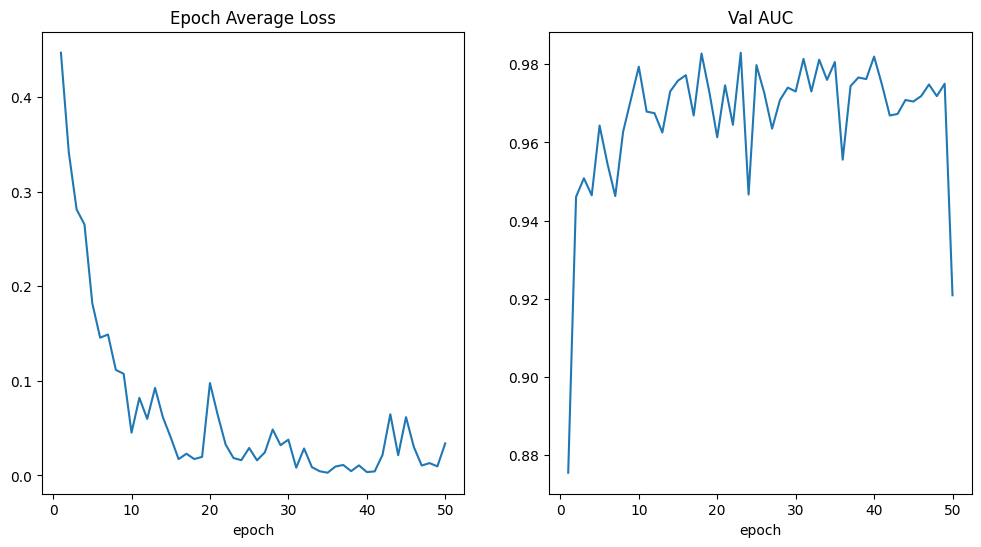

In [26]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

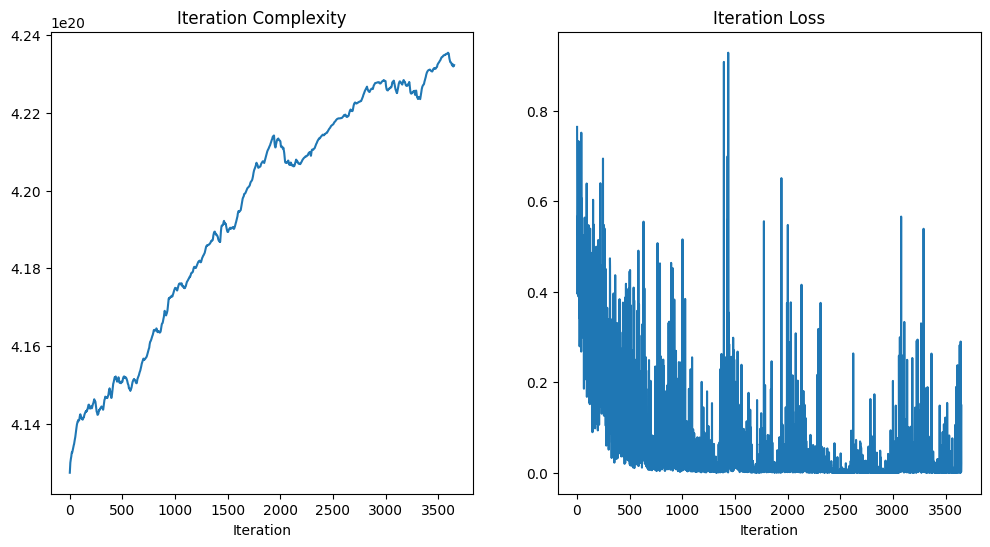

In [27]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Iteration Loss")
x = [val_interval * (i + 1) for i in range(len(single_loss))]
y = single_loss
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
fig.savefig('complexity.png')


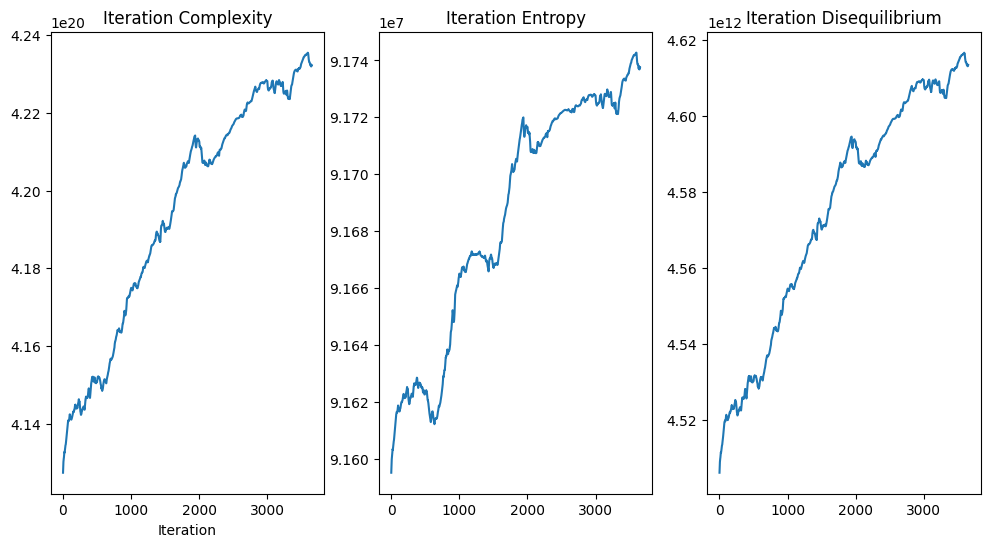

In [29]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,3,2)
plt.title("Iteration Entropy")
y2 = single_entropy
plt.plot(x, y2)
plt.subplot(1,3,3)
plt.title("Iteration Disequilibrium")
y3 = single_disequilibrium
plt.plot(x, y3)

plt.show()

In [30]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ('0', '1')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

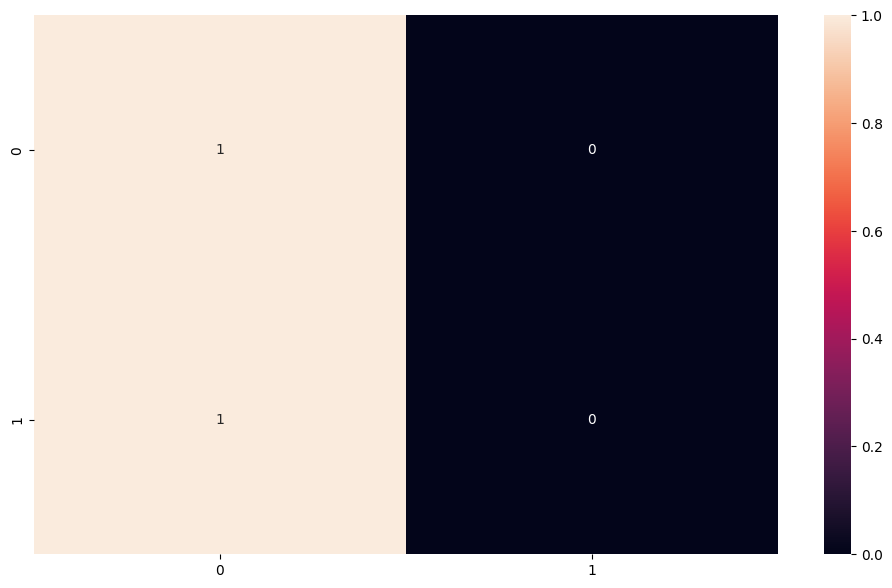

In [34]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [31]:
from sklearn.metrics import classification_report as cr
from sklearn.metrics import balanced_accuracy_score as ba
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as cm_display


Balanced Accuracy: 0.5

Regular Accuracy: 0.5547945205479452

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        81
           1       0.00      0.00      0.00        65

    accuracy                           0.55       146
   macro avg       0.28      0.50      0.36       146
weighted avg       0.31      0.55      0.40       146



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


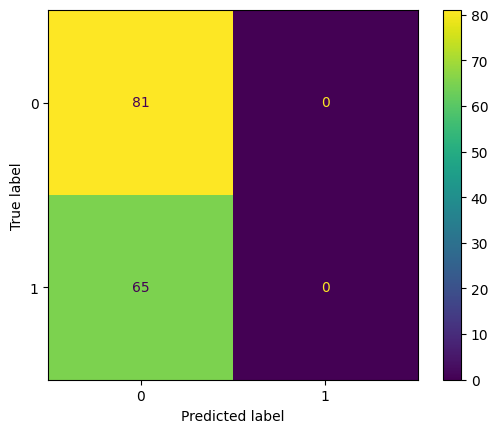

In [32]:
def evaluate_prediction(y_true, y_pred):
    
    print('')
    print('Balanced Accuracy:',ba(y_true, y_pred))
    print('')
    print('Regular Accuracy:', acc(y_true, y_pred))
    print('')
    print('Classification Report:')
    print(cr(y_true, y_pred))
    
    cm_matrix = cm(y_true, y_pred).astype(np.float32)
    
    disp = cm_display(cm_matrix)
    disp.plot()
    plt.savefig('confusion_matrix.png')
    plt.show()

evaluate_prediction(y_true, y_pred)